In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import RocCurveDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import joblib

Ingestion des données

In [41]:
df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [42]:
#Strecture de la dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [43]:
len(df['customerID']) == len(df)

True

Alors en peut supprimer cette colones car ne fourni aucune information pour la modélisation

In [44]:
df.drop('customerID', axis=1, inplace= True)

In [45]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [46]:
#Variable_Cible
df['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

In [47]:
#Transformation de la variables cibles en une variable numérique binaire
# 0: le client n'est pas désabonné; 1: abonné
df['Churn'] = df['Churn'].apply(lambda val: 0 if val == "No" else 1)

In [48]:
df['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [49]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

In [50]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Dévision en données d'entrainement/validation/test

In [51]:
seed = 123

train, test = train_test_split(df, test_size=0.3, random_state=seed, stratify=df['Churn'])
test, validate = train_test_split(test, test_size=0.5, random_state=seed, stratify=test['Churn'])

print("train data: ", train.shape)
print("Validation data: ", validate.shape)
print("test data: ", test.shape)

train data:  (4930, 20)
Validation data:  (1057, 20)
test data:  (1056, 20)


In [52]:
train['Churn'].value_counts(normalize=True)

0    0.734686
1    0.265314
Name: Churn, dtype: float64

In [53]:
validate['Churn'].value_counts(normalize=True)

0    0.734153
1    0.265847
Name: Churn, dtype: float64

In [54]:
test['Churn'].value_counts(normalize=True)

0    0.734848
1    0.265152
Name: Churn, dtype: float64

In [55]:
#Enregistrement des diff ensemble de données
train.to_csv('./data/train.csv', index=False)
validate.to_csv('./data/validate.csv', index=False)
test.to_csv('./data/test.csv', index=False)

Analyse exploratoire des données

In [56]:
# Copie des données d'entrainement
train_copy = train.copy()

In [57]:
train_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,4930.0,0.155781,0.362684,0.00,0.00,0.0,0.0000,1.00
tenure,4930.0,32.207911,24.628948,0.00,8.00,29.0,55.0000,72.00
MonthlyCharges,4930.0,64.684189,29.962114,18.55,35.75,70.3,89.6875,118.75
Churn,4930.0,0.265314,0.441545,0.00,0.00,0.0,1.0000,1.00


In [58]:
# Variables qualitatives
cat_cols = train_copy.select_dtypes(include='object').columns.to_list()
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges']

In [59]:
# Variables quantitatives
quant_cols = train_copy.select_dtypes(exclude='object').columns.to_list()
quant_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']

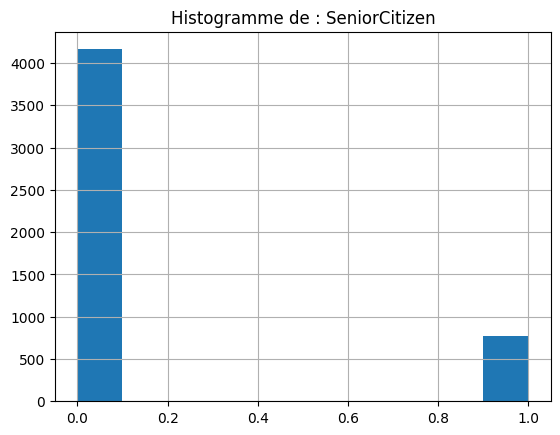

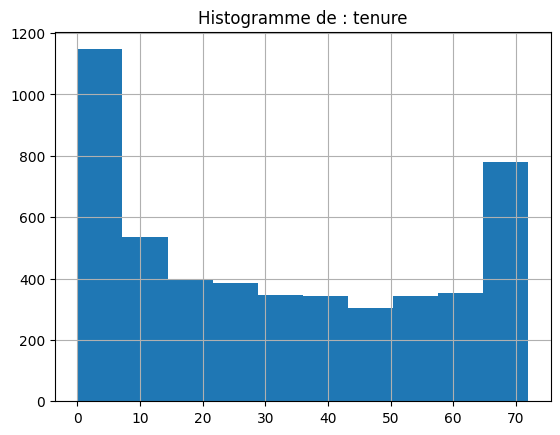

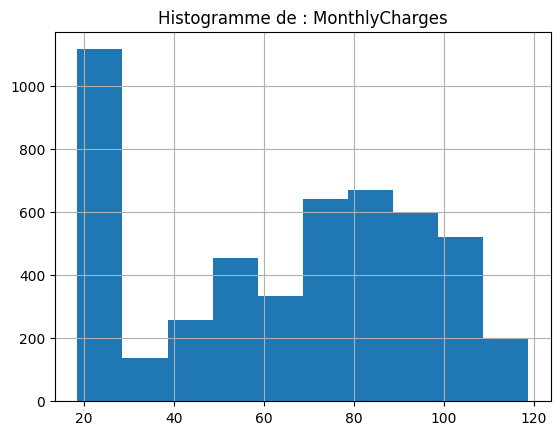

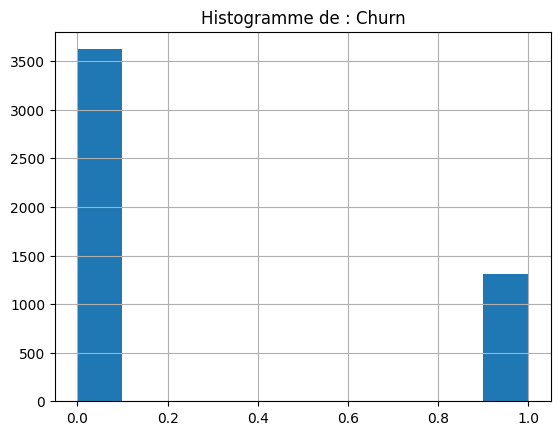

In [60]:
# Histogramme de chaque variable quantitative
for col in quant_cols:
    train_copy[col].hist()
    plt.title("Histogramme de : "+col)
    plt.show()
    plt.close()

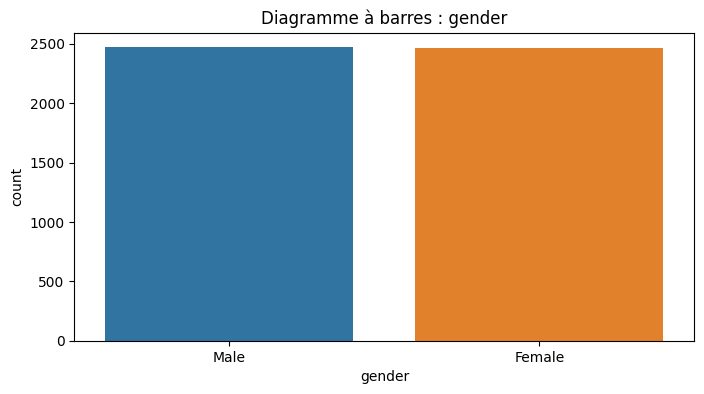

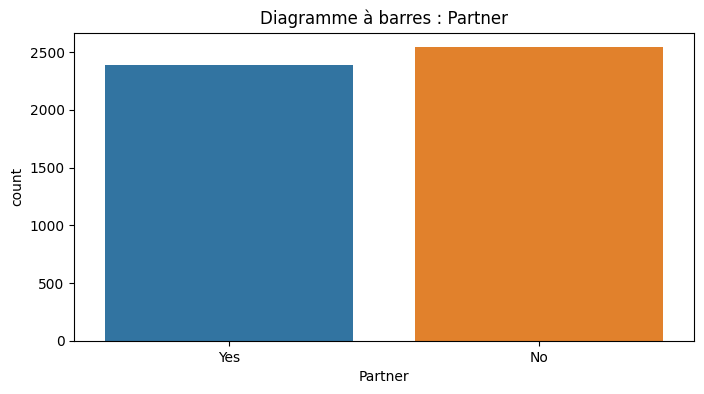

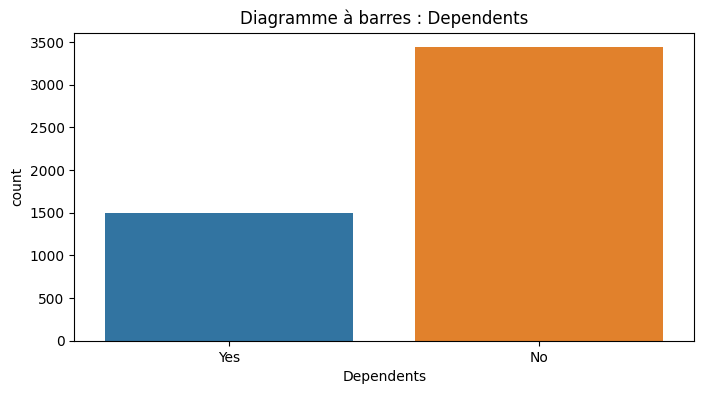

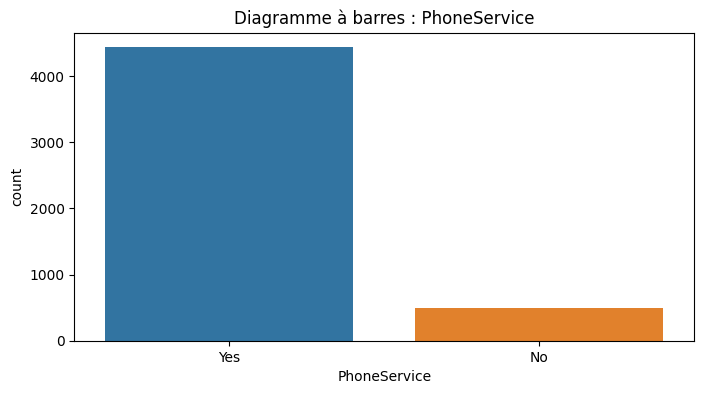

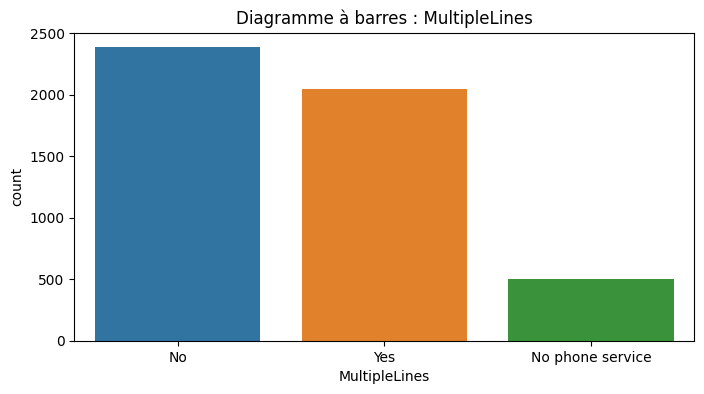

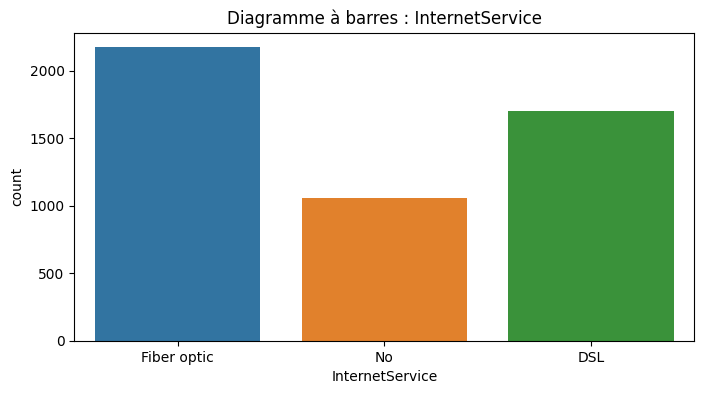

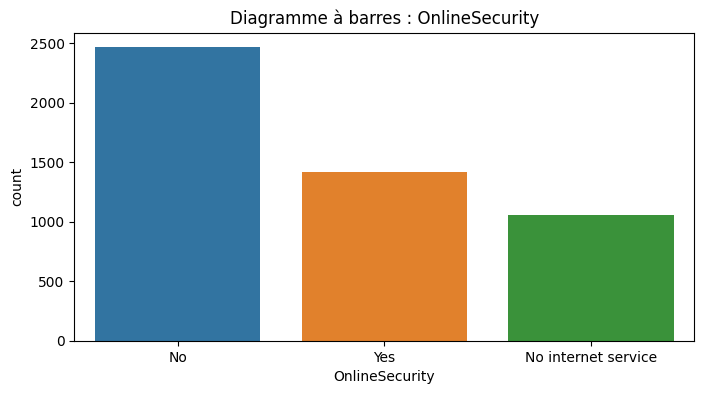

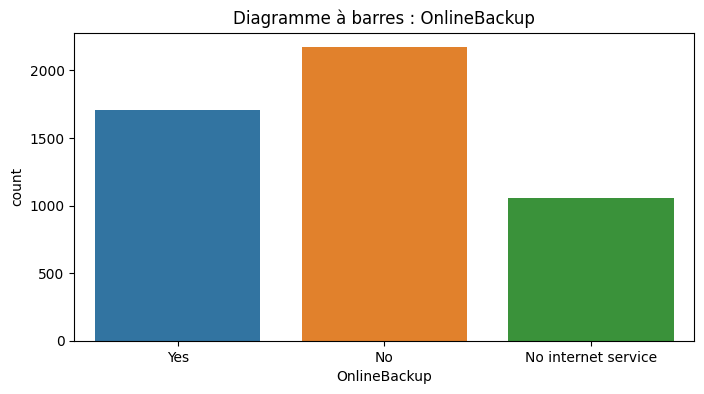

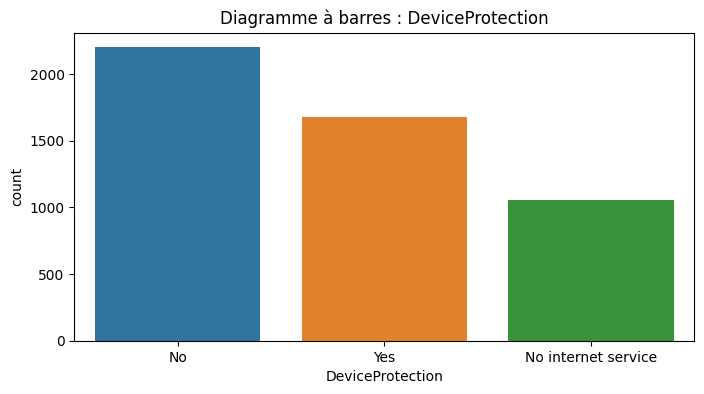

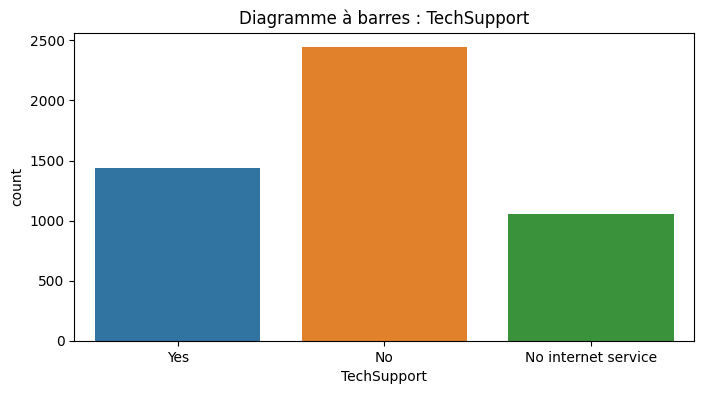

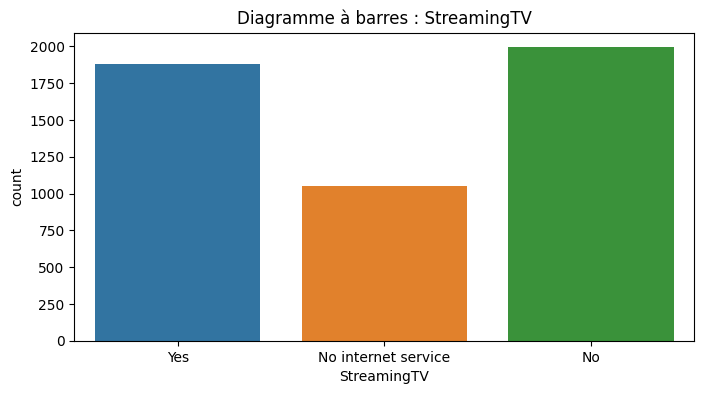

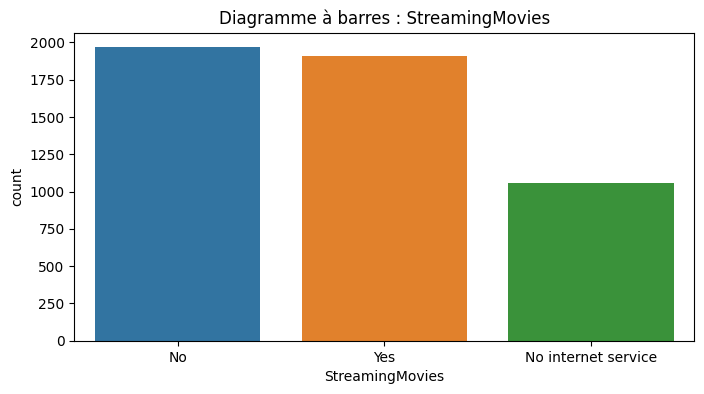

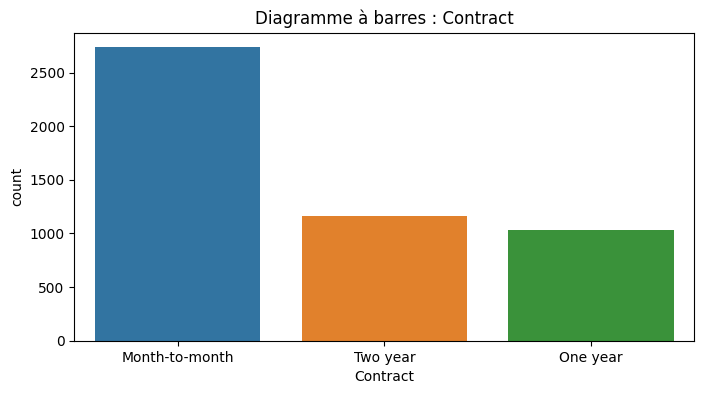

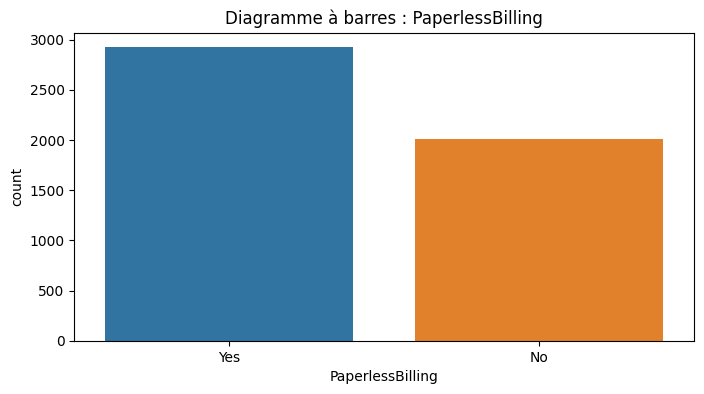

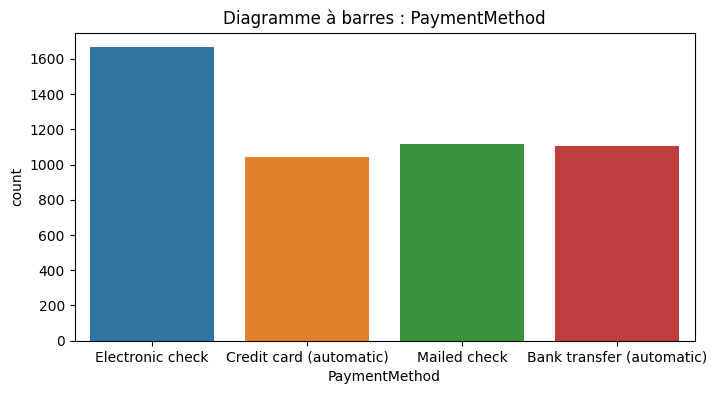

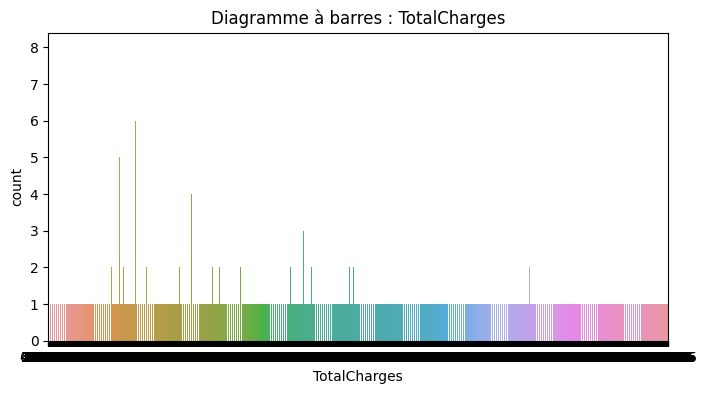

In [61]:
# Diagramme à barres de chaque variable qualitative
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=train_copy, x=col)
    plt.title("Diagramme à barres : "+col)
    plt.show()
    plt.close()

In [62]:
# Matrice de corrélations
train_corr = train_copy.corr(numeric_only=True)
train_corr

,SeniorCitizen,tenure,MonthlyCharges,Churn
SeniorCitizen,1.000000,0.006503,0.224643,0.163730
tenure,0.006503,1.000000,0.241675,-0.354819
MonthlyCharges,0.224643,0.241675,1.000000,0.193961
Churn,0.163730,-0.354819,0.193961,1.000000


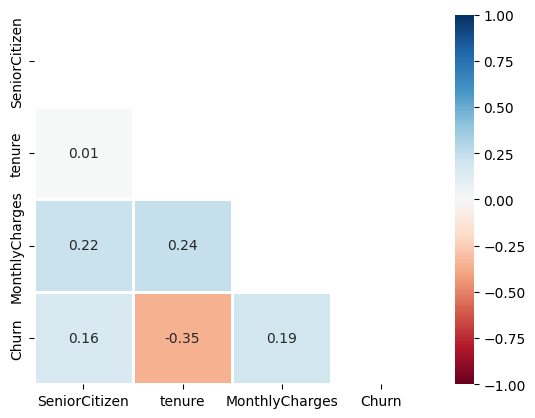

In [63]:
# Carte des correlations
sns.heatmap(
    train_corr,
    mask=np.triu(np.ones_like(train_corr, dtype=bool)),
    center=0, cmap='RdBu', linewidths=1, annot=True,
    fmt=".2f", vmin=-1, vmax=1
)
plt.show()
plt.close()

Prétraitement des données 

In [64]:
total_charges = pd.to_numeric(train_copy['TotalCharges'], errors='coerce')
total_charges.isna().sum()

8

In [66]:
train_copy[total_charges.isna()]['TotalCharges'].unique()

array([' '], dtype=object)

Ce sont donc les espaces ' ' qui causaient probleme au niveau de la variables TotalCharges

Créons un pipeline pour le prétraitement des données avant la phase de modélisation

In [67]:
# Fonction pour regler le problem de la colonne 'TotalCharges'
def convert_totalcharges(x):
    # X : dataframe 
    Z = x.copy()
    Z['TotalCharges'] = pd.to_numeric(Z['TotalCharges'], errors='coerce')
    return Z.values

In [68]:
numeric_features = quant_cols[:-1] + ['TotalCharges']
numeric_features

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [69]:
categorical_features = cat_cols[:-1]
categorical_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [71]:
# Pipeline de prétraitement des variables independantes numérique 
numeric_transformer = Pipeline(
    steps= [ ('convert', FunctionTransformer(convert_totalcharges)),
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
    ]
)

# Pipeline de prétraitement des variables independantes qualitative
categorical_transformer = Pipeline(
    steps=[('onehotencoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))]
) 

# Combinaison des deux précédents pipelines en un seul
preprocessor = ColumnTransformer(
    transformers=[('numeric', numeric_transformer, numeric_features),
                ('categorical', categorical_transformer, categorical_features) ]
)

print(preprocessor)


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('convert',
                                                  FunctionTransformer(func=<function convert_totalcharges at 0x000001A07313C310>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneSer

In [72]:
# Image du pipeline de pretraitement 
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('convert',
                                                  FunctionTransformer(func=<function convert_totalcharges at 0x000001A07313C310>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

Modélisation

In [73]:
# Construction du pipeline de modélisation avec l'algorithme Random Forest comme estimateur
rf_pipe_model = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('rf', RandomForestClassifier(random_state=seed))]
)

rf_pipe_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x000001A07313C310>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('on...encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('rf', RandomForestClassifier(random_state=123))])

In [74]:
# Construction du pipeline de modélisation avec l'algorithme régression liniére comme estimateur
logreg_pipe_model = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('logreg', LogisticRegression(random_state=seed, max_iter=2000))]
)

logreg_pipe_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x000001A07313C310>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('on...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('logreg',
                 LogisticRegression(max_iter=2000, random_state=123))])

In [76]:
X_train, X_val, y_train, y_val = train.drop('Churn', axis=1), validate.drop('Churn', axis=1), train['Churn'], validate['Churn']
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, '\n')

(4930, 19) (4930,) (1057, 19) (1057,) 



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      1308

    accuracy                           1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930



              precision    recall  f1-score   support

           0       0.81      0.89      0.85       776
           1       0.59      0.43      0.50       281

    accuracy                           0.77      1057
   macro avg       0.70      0.66      0.67      1057
weighted avg       0.75      0.77      0.76      1057



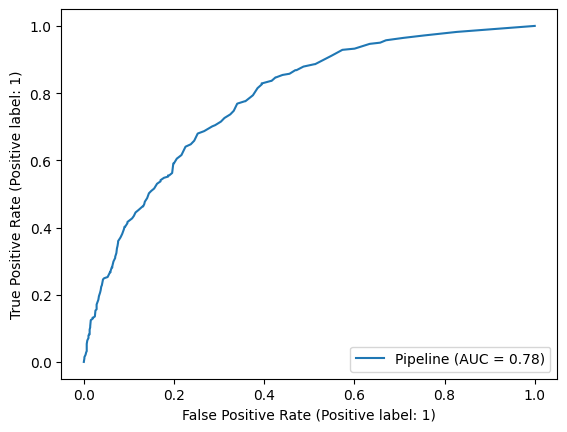

In [78]:
# Formation du modéle de Random forest  
rf_pipe_model.fit(X_train, y_train)

# Prédiction sur les données d'entrainement
y_train_preds_rf = rf_pipe_model.predict(X_train)

# Prediction sur les données de validation 
y_val_preds_rf = rf_pipe_model.predict(X_val)

# Rapports de classification 
print(classification_report(y_train, y_train_preds_rf))
print('\n')
print(classification_report(y_val, y_val_preds_rf))

# Courbe ROC 
rf_roc = RocCurveDisplay.from_estimator(rf_pipe_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3622
           1       0.66      0.55      0.60      1308

    accuracy                           0.80      4930
   macro avg       0.75      0.72      0.74      4930
weighted avg       0.80      0.80      0.80      4930



              precision    recall  f1-score   support

           0       0.83      0.89      0.86       776
           1       0.62      0.48      0.54       281

    accuracy                           0.78      1057
   macro avg       0.72      0.69      0.70      1057
weighted avg       0.77      0.78      0.77      1057



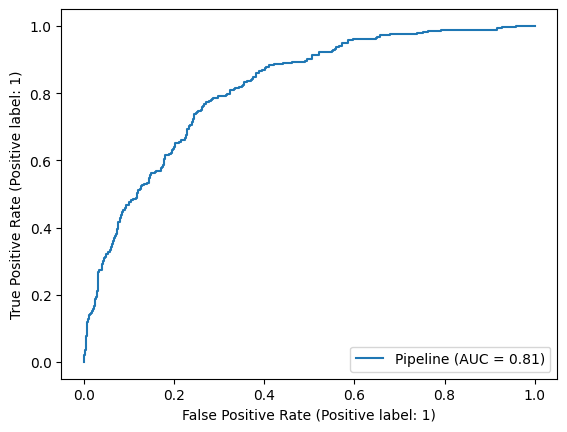

In [79]:
# Formation du modéle de reg logistique  
logreg_pipe_model.fit(X_train, y_train)

# Prédiction sur les données d'entrainement
y_train_preds_logreg = logreg_pipe_model.predict(X_train)

# Prediction sur les données de validation 
y_val_preds_logreg = logreg_pipe_model.predict(X_val)

# Rapports de classification 
print(classification_report(y_train, y_train_preds_logreg))
print('\n')
print(classification_report(y_val, y_val_preds_logreg))

# Courbe ROC 
logreg_roc = RocCurveDisplay.from_estimator(logreg_pipe_model, X_val, y_val)

D'apres les resultats le model de regression logestique est meilleur que celui de random forest, Nous allons proceder au reglage des  hyperparametre de ce modele:

Reglage des hyperparametres du modele

In [85]:
# Réglage des hyperparametres du model de regression logistique

pipeline_model = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('logreg', LogisticRegression(random_state=seed, max_iter=2000))]
)

param_grid = {
    'logreg__solver' : ['lbfgs', 'saga', 'sag', 'newton-cg', 'newton-cholesky'],
    'logreg__penalty' : ['l2', None],
    'logreg__C' : [0.5, 1.0, 5.0, 10.0]
}

search_model = GridSearchCV(
    estimator = pipeline_model,
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv=5,
    n_jobs=-1
)

search_model.fit(X_train, y_train)

print(search_model.best_params_)

print(search_model.best_score_)


{'logreg__C': 5.0, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
0.8443050118043238


In [82]:
# Enregistrement du meilleur modele 
joblib.dump(search_model.best_estimator_,'./Models/best_model.pkl')

['./Models/best_model.pkl']

Analyse de la performance du meilleur modele sur les donnees de test 

In [83]:
# Chargemant du meilleur modele 
loaded_model = joblib.load('./Models/best_model.pkl')
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x000001A07313C310>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('on...
                                                                                 sparse_output=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('logreg',
                 LogisticRegression(C=0.5, max_iter=2000, penalty=None,
                                    random_state=123, solver='saga'))])

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       776
           1       0.71      0.59      0.64       280

    accuracy                           0.83      1056
   macro avg       0.78      0.75      0.76      1056
weighted avg       0.82      0.83      0.82      1056



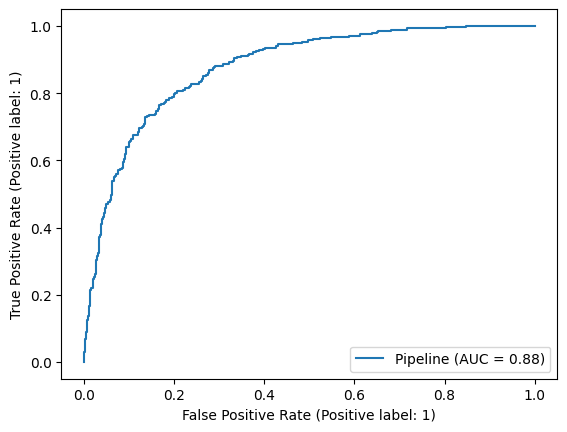

In [84]:
# Prédiction sur les donnes de test 
X_test, y_test = test.drop('Churn', axis=1), test['Churn']
y_test_preds = loaded_model.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_test_preds))

# Courbe ROC
roc_plot = RocCurveDisplay.from_estimator(loaded_model, X_test, y_test)

** Qualité du code **
autopep8 --in-place --agressive --agressive churn_library.py

pylint churn_library.py